This is from https://www.youtube.com/watch?v=PaCmpygFfXo&list=PPSV

In [ ]:
words = open("names.txt", "r").read().splitlines()

In [ ]:
len(words)

32033

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
import torch
N = torch.ones((27, 27), dtype=torch.int32)

In [ ]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

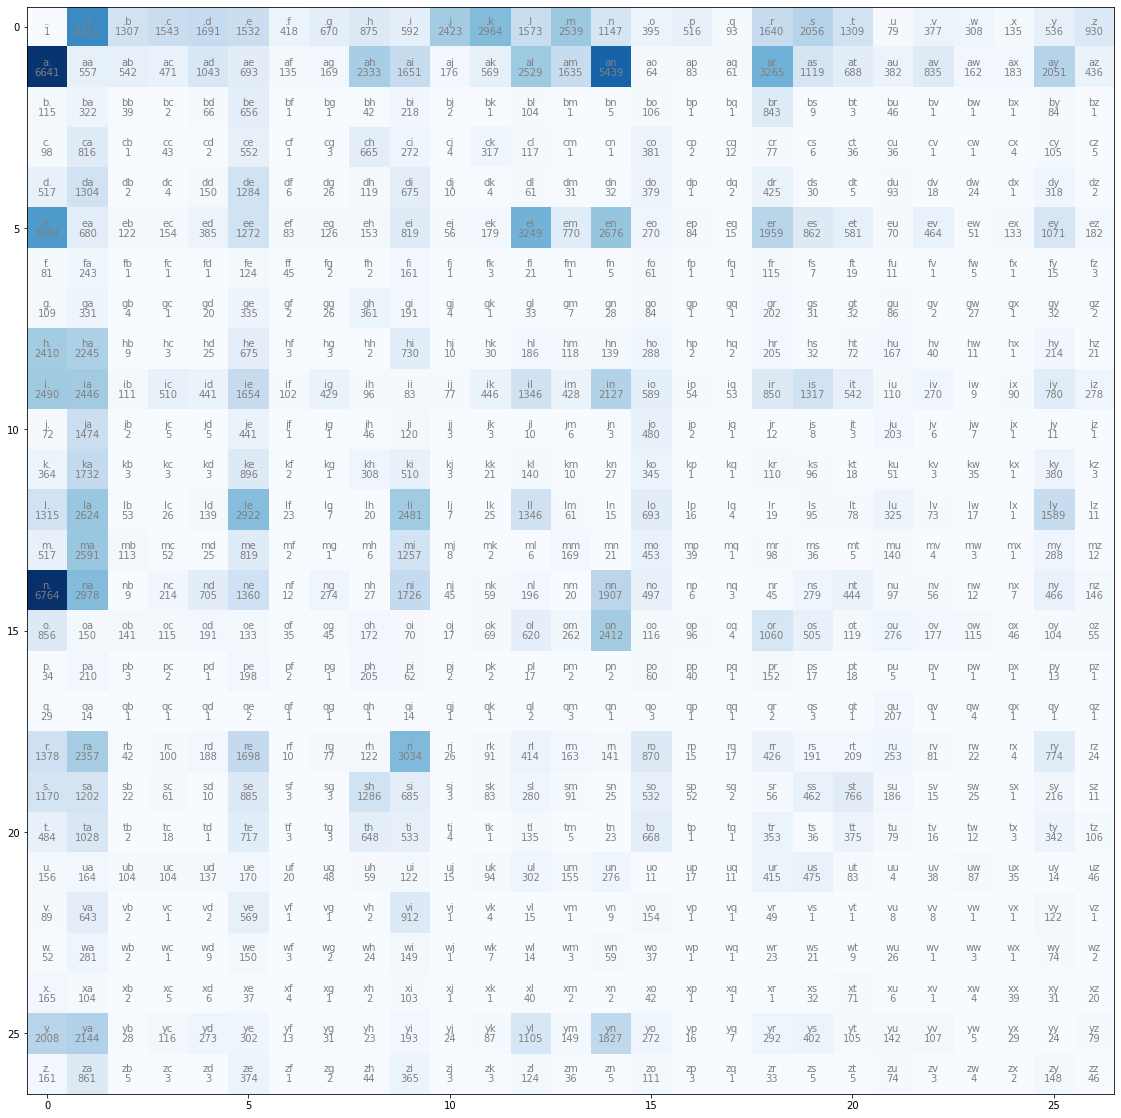

In [ ]:
import matplotlib.pyplot as plt
#matplotlib lnline

plt.figure(figsize=(20, 20))
plt.imshow(N, cmap='Blues')
for i in range(27):
  for j in range(27):
    chatr = itos[i] + itos[j]
    plt.text(j, i, chatr, ha="center", va="bottom", color="grey")
    plt.text(j, i, N[i,j].item(), ha="center", va="top", color="grey")


In [ ]:
# consrtuct probability tensor
P = N.float()
P = P / P.sum(dim=1, keepdim=True)

In [ ]:
p = P[0]
p

tensor([3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
        1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
        4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
        5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
        4.2109e-03, 1.6719e-02, 2.9008e-02])

In [ ]:
g = torch.Generator().manual_seed(1024)
for i in range(10):
  out = []
  ix = 0
  while(True):
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))
  

jelosa.
jaia.
don.
atasovyeseiniikerlila.
vas.
malyncamelaberos.
selya.
kwsheerianisto.
enda.
qull.


In [ ]:
# average negative log likelyhood - loss function
# likelyhood is product of all the probabilities
log_likelyhood = 0
n = 0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelyhood += logprob
    n += 1
    # print(f"{ch1}{ch2}: {prob:.4f} {logprob:0.4f}")

print(f"{log_likelyhood=}")
nll = -log_likelyhood
print(f"{nll=}")
print(f"{nll/n}") # taking the average

log_likelyhood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


In [ ]:
log_likelyhood = 0
n = 0
for w in ["andrejq"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelyhood += logprob
    n += 1
    print(f"{ch1}{ch2}: {prob:.4f} {logprob:0.4f}")

print(f"{log_likelyhood=}")
nll = -log_likelyhood
print(f"{nll=}")
print(f"{nll/n}")

.a: 0.1376 -1.9835
an: 0.1604 -1.8302
nd: 0.0384 -3.2594
dr: 0.0770 -2.5646
re: 0.1334 -2.0143
ej: 0.0027 -5.9004
jq: 0.0003 -7.9817
q.: 0.0970 -2.3331
log_likelyhood=tensor(-27.8672)
nll=tensor(27.8672)
3.4834020137786865


In [ ]:
## NOW USING SGD

In [ ]:
# create training set for all the bigrams
xs, ys = [], []
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [ ]:
xs

tensor([ 0,  5, 13, 13,  1])

In [ ]:
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
import torch.nn.functional as F

<matplotlib.image.AxesImage>

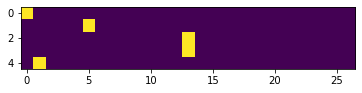

In [ ]:
xenc = F.one_hot(xs, num_classes=27).float()
plt.imshow(xenc)

In [ ]:
xenc.dtype

torch.float32

In [ ]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [ ]:
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W # log counts
# below 2 steps together is soft max !!!
counts = logits.exp() # counts - equivalent to the N array
probs = counts / counts.sum(dim=1, keepdim=True) # prob distro

In [ ]:
probs.shape

torch.Size([5, 27])

In [ ]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram
  x = xs[i].item() # input index
  y = ys[i].item() # label index
  print("------------")
  print(f"bigram example {i+1}: {itos[x]}{itos[y]} (indexes: {x},{y})")
  print(f"input to the neural net: {x}")
  print(f"output probability from the net: {probs[i]}")
  print(f"label (actual next char): {y}")
  p = probs[i, y]
  print(f"probability assigned by net to next char: {p}")
  logp = torch.log(p)
  print(f"log likelyhood: {logp.item()}")
  nll = -logp
  print(f"neg log likelyhood: {nll.item()}")
  nlls[i] = nll

print("===============")
print(f"average nll i.e. loss: {nlls.mean().item()}")
  

------------
bigram example 1: .e (indexes: 0,5)
input to the neural net: 0
output probability from the net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next char): 5
probability assigned by net to next char: 0.01228625513613224
log likelyhood: -4.399273872375488
neg log likelyhood: 4.399273872375488
------------
bigram example 2: em (indexes: 5,13)
input to the neural net: 5
output probability from the net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next char): 13
probability assigned by net to next char: 0.018050700426101685
log likelyhood: -4.014570713043213
neg log l

In [ ]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [ ]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W # log counts
# below 2 steps together is soft max !!!
counts = logits.exp() # counts - equivalent to the N array
probs = counts / counts.sum(dim=1, keepdim=True) # prob distro
loss = -probs[torch.arange(5), ys].log().mean()

In [ ]:
print(f"loss: {loss.item()}")

loss: 3.6692662239074707


In [ ]:
# backward pass
W.grad = None # efficient way to set to zero
loss.backward()

In [ ]:
W.data += -0.1 * W.grad

In [ ]:
# PUTTING IT ALL TOGETHER

xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f"num examples: {num}")

# initialize the "network"
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

num examples: 228146


In [ ]:
# gradient descent

for k in range(100):
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc @ W # log counts
  counts = logits.exp() # counts - equivalent to the N array
  probs = counts / counts.sum(dim=1, keepdim=True) # prob distro
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # regularization to force W's to be close to zeroes
  print(f"loss: {loss.item()}")
  
  # backward pass
  W.grad = None # efficient way to set to zero
  loss.backward()
  
  # update weights
  W.data += -50 * W.grad

loss: 2.4834256172180176
loss: 2.4833858013153076
loss: 2.4833483695983887
loss: 2.4833130836486816
loss: 2.4832794666290283
loss: 2.483247756958008
loss: 2.4832165241241455
loss: 2.483186960220337
loss: 2.4831581115722656
loss: 2.4831299781799316
loss: 2.483103036880493
loss: 2.483076333999634
loss: 2.48305082321167
loss: 2.4830260276794434
loss: 2.483001232147217
loss: 2.4829773902893066
loss: 2.482954263687134
loss: 2.48293137550354
loss: 2.4829092025756836
loss: 2.4828872680664062
loss: 2.482865571975708
loss: 2.4828453063964844
loss: 2.4828243255615234
loss: 2.482804298400879
loss: 2.4827845096588135
loss: 2.482764959335327
loss: 2.48274564743042
loss: 2.482727289199829
loss: 2.482708692550659
loss: 2.4826903343200684
loss: 2.4826724529266357
loss: 2.4826548099517822
loss: 2.482637643814087
loss: 2.4826207160949707
loss: 2.4826037883758545
loss: 2.4825870990753174
loss: 2.4825708866119385
loss: 2.4825549125671387
loss: 2.482538938522339
loss: 2.482522964477539
loss: 2.482507705688

In [ ]:
# Finally - sample
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
  out = []
  ix = 0
  while(True):
    # p = P[ix]
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(dim=1, keepdim=True) # prob distro
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchthizarie.


In [ ]:
mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.